# Image Embedding Extractor

In [1]:
import random

import numpy as np
import torch
import random

from extractors.face_extractors.face_detection import FaceDetection
from extractors.face_extractors.face_alignment import FaceAlignment
from extractors.face_extractors.face_normalizer import FaceNormalizer
from extractors.face_extractors.face_emotion_recognizer import FaceEmotionRecognizer
from extractors.face_extractors.face_extractor import FaceEmbeddingExtractor

fd = FaceDetection("MTCNN", minimum_confidence=0.95)
fa = FaceAlignment()
fn = FaceNormalizer()

model_name = "enet_b0_8_best_afew"
# model_name = 'enet_b0_8_best_vgaf'
# model_name='enet_b0_8_va_mtl'
# model_name='enet_b2_8'

fer = FaceEmotionRecognizer(model_name, device="cuda:0")

fre = (
    FaceEmbeddingExtractor()
    .set_face_detection_model(fd)
    .set_face_alignment_model(fa)
    .set_face_normalizer_model(fn)
    .set_face_emotion_recognition_model(fer)
)

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


/home/ahur4/.hsemotions/enet_b0_8_best_afew.pt Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)


# Text Embedding Extraction

In [2]:
from extractors.text_extractors.text_extractor import TextEmbeddingExtractor

tee = TextEmbeddingExtractor()

Some weights of the model checkpoint at pysentimiento/robertuito-sentiment-analysis were not used when initializing RobertaModel: ['classifier.out_proj.bias', 'classifier.out_proj.weight', 'classifier.dense.bias', 'classifier.dense.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at pysentimiento/robertuito-sentiment-analysis and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predi

# Fuse Embeddings

In [3]:
# COMPLETE

1/1 [==============================] - 0s 19ms/step


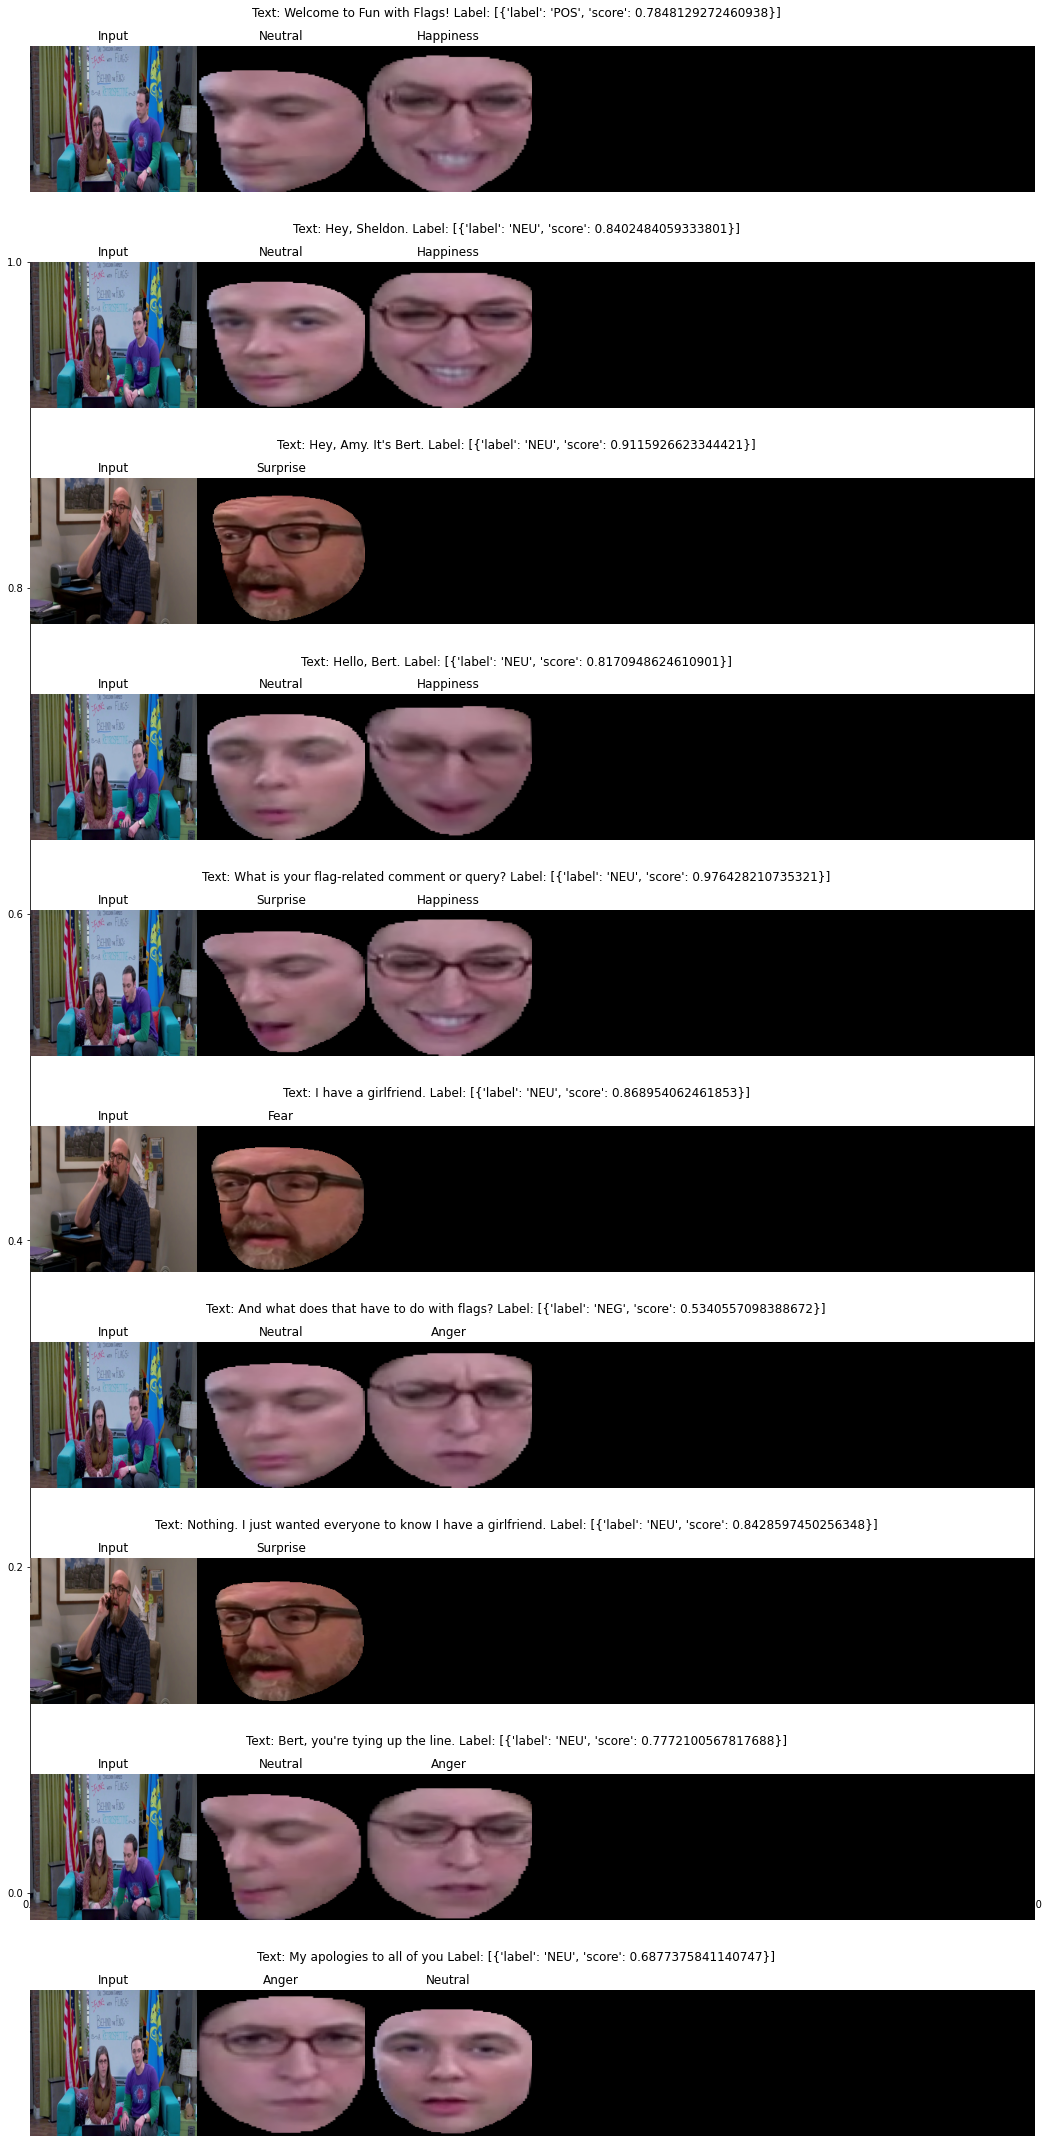

In [16]:
embedding_dimension = 2048
merged_embeddings = []
sample_size = 10

# Plot
max_faces = 5
subplots_n_column = max_faces + 1
subplots_n_row = sample_size
fig, ax_array = plt.subplots(figsize=(3 * subplots_n_column, 3 * subplots_n_row))
rows_subfigures = fig.subfigures(
    nrows=subplots_n_row,
    ncols=1,
)
######

for data_pair_index, text, image in data[:sample_size]:
    try:
        # Extract image and text embeddings and merge
        (
            faces_labels_predictions,
            scores,
            faces_representations,
        ) = fre.extract_embedding(image)
        faces_representations_mean = faces_representations.mean(axis=0)

        text_embedding = tee.extract_embedding([text])
        text_label_prediction = tee.get_labels([text])

        merged_embedding = torch.cat(
            [text_embedding.ravel(), faces_representations_mean], 0
        )

        ## todo: random randrange / grand_truth_label
        merged_embeddings.append(
            [data_pair_index, merged_embedding, random.randrange(0, 3)]
        )

        # Plot
        row_subfigure = rows_subfigures[data_pair_index]
        row_subfigure.subplots_adjust(hspace=0.0, wspace=0.0)

        row_subfigure.suptitle(
            f"Text: {text} Label: {text_label_prediction}",
        )

        axs = row_subfigure.subplots(nrows=1, ncols=subplots_n_column)
        row_subfigure.subplots_adjust(top=0.8)
        axs[0].axis("off")
        axs[0].set_title(f"Input")
        axs[0].imshow(image, aspect="auto")

        n = len(fre.faces)
        for face_index in range(max_faces):
            if face_index < n:
                axs[face_index + 1].axis("off")
                axs[face_index + 1].set_title(f"{faces_labels_predictions[face_index]}")
                axs[face_index + 1].imshow(
                    fre.normalized_rotated_faces[face_index], aspect="auto"
                )
            else:
                axs[face_index + 1].axis("off")
                axs[face_index + 1].set_title(f"")
                axs[face_index + 1].imshow(
                    np.zeros_like(fre.normalized_rotated_faces[0]), aspect="auto"
                )

    except Exception as ex:
        # no face detected
        print(ex)

plt.show()

In [28]:
from torch import nn
from multimodal_models import SimpleDenseNetwork

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = SimpleDenseNetwork(n_classes=3, embedding_dimension=embedding_dimension).to(
    device=device
)

embeddings_batch = torch.cat(
    [embedding.reshape((1, 2048)) for _, embedding, _ in merged_embeddings], dim=0
)

prediction_probabilities = model(embeddings_batch)
prediction_probabilities

tensor([[ 0.0657,  0.0211, -0.0088],
        [ 0.0311,  0.0003, -0.0263],
        [ 0.0395, -0.0043, -0.0149],
        [ 0.0569,  0.0453, -0.0273],
        [ 0.0080,  0.0122, -0.0065],
        [ 0.0390,  0.0418,  0.0025],
        [ 0.0522,  0.0150, -0.0234],
        [ 0.0351,  0.0048, -0.0169],
        [ 0.0527,  0.0216, -0.0303],
        [ 0.0069, -0.0153,  0.0090]], device='cuda:0',
       grad_fn=<AddmmBackward0>)